# Project: Dog vs Cat Classification

In [71]:
from pathlib import Path
import os
import torch
from torch import nn

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [73]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [74]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Cat, Shape: (150, 200, 3)')

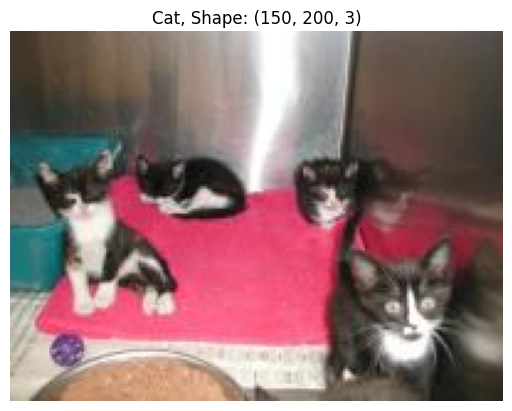

In [75]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [76]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [77]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [78]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.3216, 0.3333, 0.3412,  ..., 0.2745, 0.2627, 0.2588],
         [0.3098, 0.3255, 0.3294,  ..., 0.2745, 0.2627, 0.2588],
         [0.3059, 0.3216, 0.3255,  ..., 0.2745, 0.2627, 0.2588],
         ...,
         [0.1843, 0.1882, 0.1843,  ..., 0.8588, 0.8431, 0.8392],
         [0.1686, 0.1725, 0.1725,  ..., 0.7882, 0.8118, 0.8039],
         [0.1608, 0.1686, 0.1725,  ..., 0.6588, 0.7647, 0.7490]],

        [[0.3020, 0.3137, 0.3216,  ..., 0.2196, 0.2118, 0.2157],
         [0.2902, 0.3059, 0.3098,  ..., 0.2196, 0.2118, 0.2157],
         [0.2863, 0.3020, 0.3059,  ..., 0.2196, 0.2118, 0.2157],
         ...,
         [0.1647, 0.1686, 0.1765,  ..., 0.8314, 0.8118, 0.8000],
         [0.1608, 0.1647, 0.1725,  ..., 0.7686, 0.7843, 0.7569],
         [0.1529, 0.1608, 0.1725,  ..., 0.6353, 0.7373, 0.7098]],

        [[0.2863, 0.2980, 0.3059,  ..., 0.1686, 0.1647, 0.1725],
         [0.2745, 0.2863, 0.2941,  ..., 0.1686, 0.1647, 0.1725],
         [0.2627, 0.2784, 0.2863,  ..., 0.1686, 0.1647, 0.

Text(0.5, 1.0, 'Cat, Shape: torch.Size([3, 64, 64])')

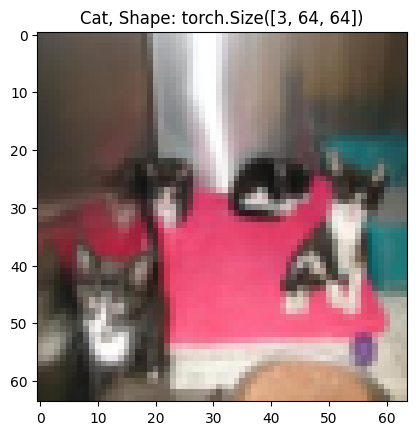

In [79]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [80]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 480
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 122
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [81]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [82]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [83]:
len(train_data), len(test_data)

(480, 122)

# Turn loaded images into 'DataLoader'

In [84]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1d0cc3dd850>,
 <torch.utils.data.dataloader.DataLoader at 0x1d0cc3d0250>)

In [85]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [86]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16,
                      out_features=output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [87]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1, bias=True)
  )
)

In [88]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [89]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[0.1004],
        [0.0862],
        [0.0963],
        [0.0779],
        [0.0729],
        [0.0762],
        [0.0974],
        [0.0868],
        [0.0976],
        [0.0800],
        [0.0779],
        [0.1059],
        [0.0868],
        [0.0809],
        [0.0927],
        [0.0834],
        [0.0894],
        [0.0854],
        [0.0831],
        [0.0933],
        [0.0808],
        [0.0964],
        [0.0764],
        [0.0858],
        [0.0779],
        [0.0823],
        [0.0870],
        [0.0693],
        [0.0973],
        [0.0894],
        [0.0745],
        [0.0840]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [90]:
from tqdm import tqdm
import time

In [91]:
epochs = 5

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

 20%|██        | 1/5 [00:01<00:05,  1.31s/it]

Epoch: 0 | Train Loss: 0.6956, Train Accuracy: 47.71 | Test Loss: 0.6934625655412674, Test Accuracy: 47.65625


 40%|████      | 2/5 [00:02<00:03,  1.26s/it]

Epoch: 1 | Train Loss: 0.6930, Train Accuracy: 50.00 | Test Loss: 0.6932060867547989, Test Accuracy: 46.875


 60%|██████    | 3/5 [00:03<00:02,  1.25s/it]

Epoch: 2 | Train Loss: 0.6911, Train Accuracy: 52.71 | Test Loss: 0.6923349648714066, Test Accuracy: 52.644230769230774


 80%|████████  | 4/5 [00:04<00:01,  1.22s/it]

Epoch: 3 | Train Loss: 0.6903, Train Accuracy: 54.79 | Test Loss: 0.6968004107475281, Test Accuracy: 47.65625


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]

Epoch: 4 | Train Loss: 0.6870, Train Accuracy: 54.58 | Test Loss: 0.6901015043258667, Test Accuracy: 53.90625
Total time: 6.063026189804077


# Plot model_0 results

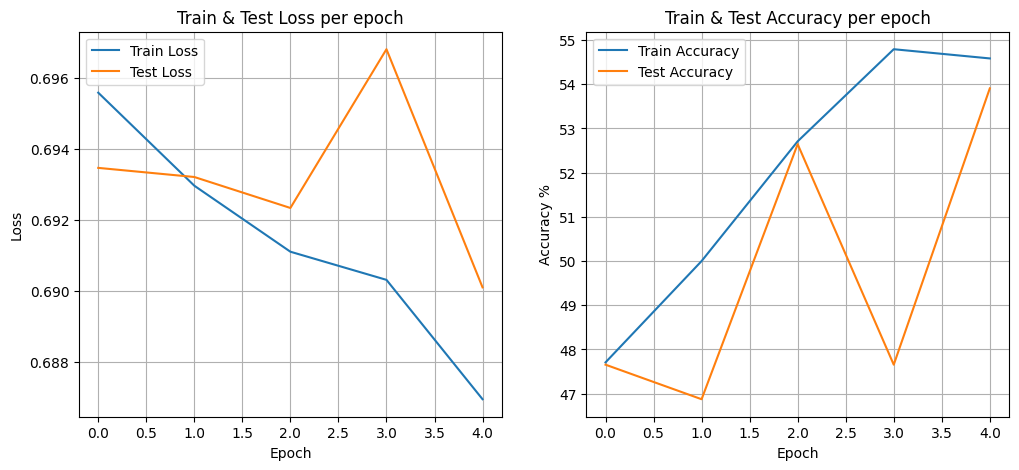

In [92]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [93]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

5 5
5 5


In [94]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [95]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [96]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [97]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 480
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 122
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normal

In [98]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x1d0decf73a0>,
 <torch.utils.data.dataloader.DataLoader at 0x1d0decf7bb0>)

In [99]:
len(class_names)

2

In [100]:
model_1 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1, bias=True)
  )
)

In [101]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0005
     maximize: False
     weight_decay: 0
 ))

In [102]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:02<01:46,  2.17s/it]

Epoch: 0 | Train Loss: 0.6950, Train Accuracy: 49.58 | Test Loss: 0.6930111795663834, Test Accuracy: 51.63934426229508


  4%|▍         | 2/50 [00:04<01:38,  2.05s/it]

Epoch: 1 | Train Loss: 0.6935, Train Accuracy: 50.00 | Test Loss: 0.6923670321702957, Test Accuracy: 50.0


  6%|▌         | 3/50 [00:06<01:37,  2.08s/it]

Epoch: 2 | Train Loss: 0.6933, Train Accuracy: 49.58 | Test Loss: 0.6926953047513962, Test Accuracy: 50.81967213114754


  8%|▊         | 4/50 [00:08<01:35,  2.09s/it]

Epoch: 3 | Train Loss: 0.6929, Train Accuracy: 50.83 | Test Loss: 0.691793292760849, Test Accuracy: 57.377049180327866


 10%|█         | 5/50 [00:10<01:30,  2.01s/it]

Epoch: 4 | Train Loss: 0.6928, Train Accuracy: 50.83 | Test Loss: 0.6913666129112244, Test Accuracy: 50.0


 12%|█▏        | 6/50 [00:12<01:28,  2.00s/it]

Epoch: 5 | Train Loss: 0.6918, Train Accuracy: 51.25 | Test Loss: 0.6898633688688278, Test Accuracy: 58.19672131147541


 14%|█▍        | 7/50 [00:14<01:26,  2.02s/it]

Epoch: 6 | Train Loss: 0.6904, Train Accuracy: 53.75 | Test Loss: 0.6881590336561203, Test Accuracy: 54.91803278688525


 16%|█▌        | 8/50 [00:16<01:25,  2.05s/it]

Epoch: 7 | Train Loss: 0.6910, Train Accuracy: 49.79 | Test Loss: 0.6860122531652451, Test Accuracy: 54.91803278688525


 18%|█▊        | 9/50 [00:18<01:24,  2.07s/it]

Epoch: 8 | Train Loss: 0.6862, Train Accuracy: 54.58 | Test Loss: 0.6840064972639084, Test Accuracy: 58.19672131147541


 20%|██        | 10/50 [00:20<01:23,  2.09s/it]

Epoch: 9 | Train Loss: 0.6842, Train Accuracy: 53.12 | Test Loss: 0.6853157579898834, Test Accuracy: 51.63934426229508


 22%|██▏       | 11/50 [00:23<01:25,  2.19s/it]

Epoch: 10 | Train Loss: 0.6813, Train Accuracy: 56.25 | Test Loss: 0.6844590455293655, Test Accuracy: 51.63934426229508


 24%|██▍       | 12/50 [00:25<01:29,  2.36s/it]

Epoch: 11 | Train Loss: 0.6802, Train Accuracy: 56.67 | Test Loss: 0.6725330203771591, Test Accuracy: 55.73770491803278


 26%|██▌       | 13/50 [00:27<01:23,  2.27s/it]

Epoch: 12 | Train Loss: 0.6940, Train Accuracy: 53.12 | Test Loss: 0.6766190081834793, Test Accuracy: 57.377049180327866


 28%|██▊       | 14/50 [00:29<01:17,  2.15s/it]

Epoch: 13 | Train Loss: 0.6842, Train Accuracy: 56.67 | Test Loss: 0.6842180341482162, Test Accuracy: 60.65573770491803


 30%|███       | 15/50 [00:31<01:13,  2.11s/it]

Epoch: 14 | Train Loss: 0.6827, Train Accuracy: 56.67 | Test Loss: 0.68162040412426, Test Accuracy: 61.47540983606557


 32%|███▏      | 16/50 [00:33<01:11,  2.11s/it]

Epoch: 15 | Train Loss: 0.6741, Train Accuracy: 58.54 | Test Loss: 0.6756543219089508, Test Accuracy: 57.377049180327866


 34%|███▍      | 17/50 [00:35<01:08,  2.08s/it]

Epoch: 16 | Train Loss: 0.6844, Train Accuracy: 56.67 | Test Loss: 0.6722365468740463, Test Accuracy: 55.73770491803278


 36%|███▌      | 18/50 [00:37<01:05,  2.03s/it]

Epoch: 17 | Train Loss: 0.6801, Train Accuracy: 53.54 | Test Loss: 0.6676965802907944, Test Accuracy: 58.19672131147541


 38%|███▊      | 19/50 [00:39<01:01,  1.99s/it]

Epoch: 18 | Train Loss: 0.6631, Train Accuracy: 59.79 | Test Loss: 0.6566532552242279, Test Accuracy: 66.39344262295081


 40%|████      | 20/50 [00:41<00:58,  1.96s/it]

Epoch: 19 | Train Loss: 0.6676, Train Accuracy: 60.42 | Test Loss: 0.660518079996109, Test Accuracy: 61.47540983606557


 42%|████▏     | 21/50 [00:43<00:56,  1.94s/it]

Epoch: 20 | Train Loss: 0.6496, Train Accuracy: 61.67 | Test Loss: 0.6696197688579559, Test Accuracy: 59.83606557377049


 44%|████▍     | 22/50 [00:45<00:54,  1.93s/it]

Epoch: 21 | Train Loss: 0.6497, Train Accuracy: 63.54 | Test Loss: 0.6715545654296875, Test Accuracy: 63.934426229508205


 46%|████▌     | 23/50 [00:47<00:52,  1.93s/it]

Epoch: 22 | Train Loss: 0.6590, Train Accuracy: 59.58 | Test Loss: 0.6729301363229752, Test Accuracy: 58.19672131147541


 48%|████▊     | 24/50 [00:49<00:49,  1.91s/it]

Epoch: 23 | Train Loss: 0.6773, Train Accuracy: 58.13 | Test Loss: 0.671081617474556, Test Accuracy: 51.63934426229508


 50%|█████     | 25/50 [00:51<00:49,  1.97s/it]

Epoch: 24 | Train Loss: 0.6574, Train Accuracy: 59.79 | Test Loss: 0.6555253565311432, Test Accuracy: 56.557377049180324


 52%|█████▏    | 26/50 [00:53<00:48,  2.04s/it]

Epoch: 25 | Train Loss: 0.6693, Train Accuracy: 57.50 | Test Loss: 0.6538652777671814, Test Accuracy: 63.934426229508205


 54%|█████▍    | 27/50 [00:55<00:47,  2.08s/it]

Epoch: 26 | Train Loss: 0.6504, Train Accuracy: 60.62 | Test Loss: 0.6666680574417114, Test Accuracy: 59.01639344262295


 56%|█████▌    | 28/50 [00:57<00:45,  2.06s/it]

Epoch: 27 | Train Loss: 0.6425, Train Accuracy: 63.96 | Test Loss: 0.6603796631097794, Test Accuracy: 59.83606557377049


 58%|█████▊    | 29/50 [00:59<00:42,  2.02s/it]

Epoch: 28 | Train Loss: 0.6448, Train Accuracy: 60.21 | Test Loss: 0.6385280638933182, Test Accuracy: 69.67213114754098


 60%|██████    | 30/50 [01:01<00:39,  1.99s/it]

Epoch: 29 | Train Loss: 0.6343, Train Accuracy: 65.42 | Test Loss: 0.707543782889843, Test Accuracy: 53.278688524590166


 62%|██████▏   | 31/50 [01:03<00:37,  1.97s/it]

Epoch: 30 | Train Loss: 0.6514, Train Accuracy: 61.88 | Test Loss: 0.6432812437415123, Test Accuracy: 64.75409836065575


 64%|██████▍   | 32/50 [01:05<00:35,  1.98s/it]

Epoch: 31 | Train Loss: 0.6483, Train Accuracy: 63.54 | Test Loss: 0.6418646275997162, Test Accuracy: 64.75409836065575


 66%|██████▌   | 33/50 [01:07<00:34,  2.02s/it]

Epoch: 32 | Train Loss: 0.6460, Train Accuracy: 60.62 | Test Loss: 0.637538231909275, Test Accuracy: 63.114754098360656


 68%|██████▊   | 34/50 [01:09<00:32,  2.05s/it]

Epoch: 33 | Train Loss: 0.6452, Train Accuracy: 62.50 | Test Loss: 0.6344381123781204, Test Accuracy: 65.57377049180327


 70%|███████   | 35/50 [01:11<00:31,  2.08s/it]

Epoch: 34 | Train Loss: 0.6243, Train Accuracy: 67.50 | Test Loss: 0.6486539244651794, Test Accuracy: 65.57377049180327


 72%|███████▏  | 36/50 [01:13<00:29,  2.10s/it]

Epoch: 35 | Train Loss: 0.6243, Train Accuracy: 65.62 | Test Loss: 0.6387171521782875, Test Accuracy: 65.57377049180327


 74%|███████▍  | 37/50 [01:15<00:26,  2.04s/it]

Epoch: 36 | Train Loss: 0.6394, Train Accuracy: 61.67 | Test Loss: 0.6451217830181122, Test Accuracy: 60.65573770491803


 76%|███████▌  | 38/50 [01:18<00:25,  2.10s/it]

Epoch: 37 | Train Loss: 0.6136, Train Accuracy: 62.71 | Test Loss: 0.6420804411172867, Test Accuracy: 68.0327868852459


 78%|███████▊  | 39/50 [01:20<00:22,  2.04s/it]

Epoch: 38 | Train Loss: 0.6332, Train Accuracy: 64.79 | Test Loss: 0.6509559527039528, Test Accuracy: 61.47540983606557


 80%|████████  | 40/50 [01:22<00:20,  2.07s/it]

Epoch: 39 | Train Loss: 0.6294, Train Accuracy: 65.00 | Test Loss: 0.6309074908494949, Test Accuracy: 63.934426229508205


 82%|████████▏ | 41/50 [01:24<00:18,  2.03s/it]

Epoch: 40 | Train Loss: 0.6424, Train Accuracy: 62.08 | Test Loss: 0.6303099244832993, Test Accuracy: 68.85245901639344


 84%|████████▍ | 42/50 [01:26<00:16,  2.01s/it]

Epoch: 41 | Train Loss: 0.6480, Train Accuracy: 62.29 | Test Loss: 0.6359770819544792, Test Accuracy: 64.75409836065575


 86%|████████▌ | 43/50 [01:28<00:14,  2.01s/it]

Epoch: 42 | Train Loss: 0.6356, Train Accuracy: 61.88 | Test Loss: 0.6188722252845764, Test Accuracy: 68.85245901639344


 88%|████████▊ | 44/50 [01:30<00:11,  1.99s/it]

Epoch: 43 | Train Loss: 0.6238, Train Accuracy: 65.42 | Test Loss: 0.625522069633007, Test Accuracy: 68.0327868852459


 90%|█████████ | 45/50 [01:32<00:10,  2.02s/it]

Epoch: 44 | Train Loss: 0.6196, Train Accuracy: 64.79 | Test Loss: 0.62143524736166, Test Accuracy: 66.39344262295081


 92%|█████████▏| 46/50 [01:33<00:07,  1.98s/it]

Epoch: 45 | Train Loss: 0.6224, Train Accuracy: 61.67 | Test Loss: 0.6254110038280487, Test Accuracy: 64.75409836065575


 94%|█████████▍| 47/50 [01:35<00:05,  1.96s/it]

Epoch: 46 | Train Loss: 0.6286, Train Accuracy: 63.12 | Test Loss: 0.6356038227677345, Test Accuracy: 66.39344262295081


 96%|█████████▌| 48/50 [01:38<00:04,  2.04s/it]

Epoch: 47 | Train Loss: 0.6229, Train Accuracy: 64.58 | Test Loss: 0.6311123743653297, Test Accuracy: 65.57377049180327


 98%|█████████▊| 49/50 [01:40<00:02,  2.08s/it]

Epoch: 48 | Train Loss: 0.6206, Train Accuracy: 65.42 | Test Loss: 0.6367424950003624, Test Accuracy: 66.39344262295081


100%|██████████| 50/50 [01:42<00:00,  2.05s/it]

Epoch: 49 | Train Loss: 0.6224, Train Accuracy: 63.54 | Test Loss: 0.6100312620401382, Test Accuracy: 67.21311475409836
Total time: 102.46166229248047


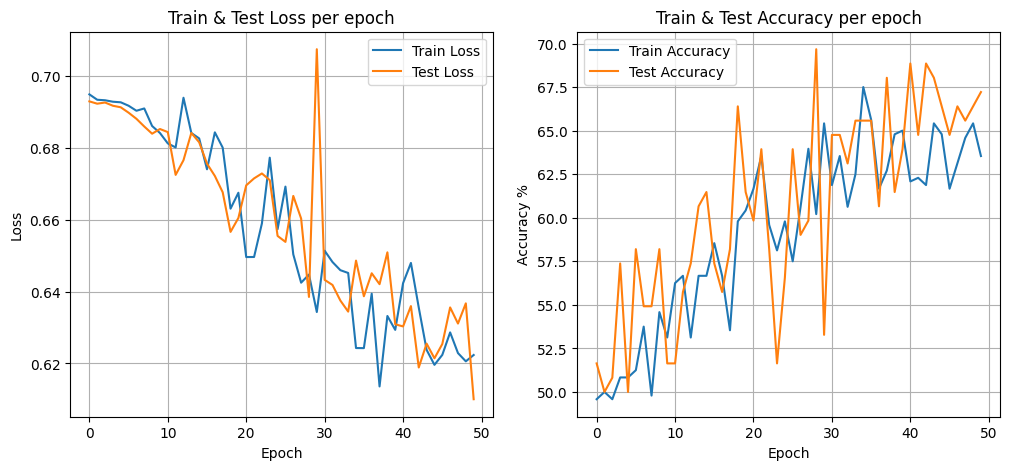

In [103]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [104]:
from torch.utils.data import Subset

In [105]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)